In [1]:
# Import des librairies
import os
import segyio
import numpy as np
import matplotlib.pyplot as plt

In [11]:
print(f"Répertoire courant : {os.getcwd()}")

Répertoire courant : /Users/patrickilunga/seam_project/notebooks


In [13]:
os.chdir("/Users/patrickilunga/seam_project")

In [14]:
filename = "data/raw/SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy"

In [15]:
print(f"Chemin utilisé : {filename}")

Chemin utilisé : data/raw/SEAM_Interpretation_Challenge_1_2DSparseGathers_Depth.sgy


In [16]:
with segyio.open(filename, ignore_geometry=True) as f:
    # Lire toutes les traces
    traces = f.trace.raw[:]  # Charge toutes les traces en mémoire

print(f"Nombre total de traces : {traces.shape[0]}")
print(f"Nombre d'échantillons par trace : {traces.shape[1]}")

Nombre total de traces : 990
Nombre d'échantillons par trace : 751


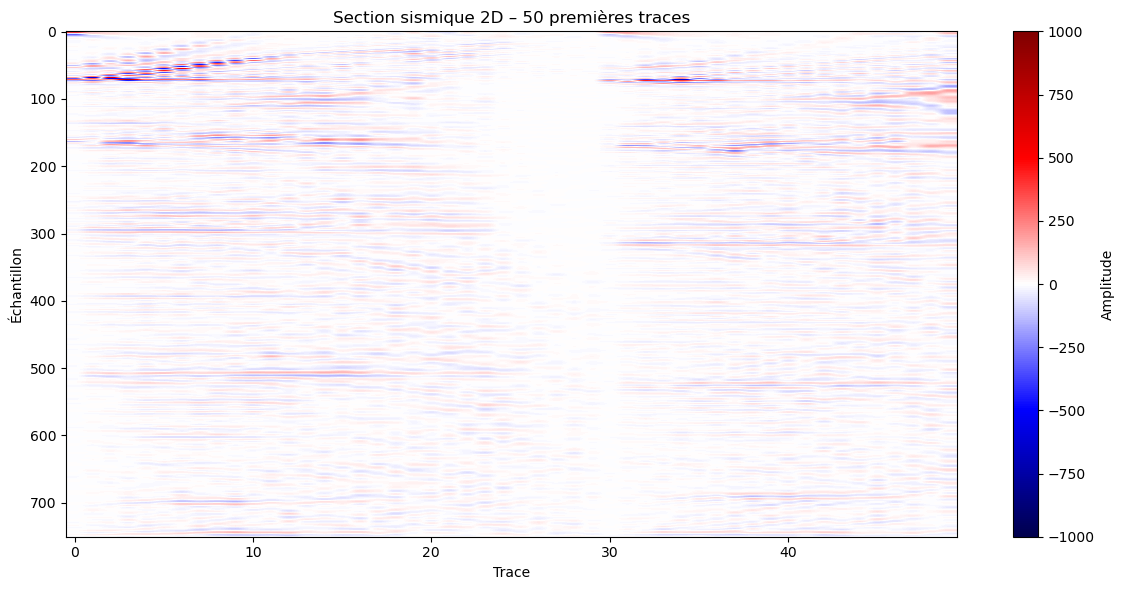

In [7]:
# Visualisation de la section sismique 2D
subset = traces[:50, :] 

plt.figure(figsize=(12, 6))
plt.imshow(subset.T, cmap="seismic", aspect="auto", vmin=-1e3, vmax=1e3)
plt.colorbar(label="Amplitude")
plt.title("Section sismique 2D – 50 premières traces")
plt.xlabel("Trace")
plt.ylabel("Échantillon")
plt.tight_layout()
#plt.savefig(os.path.join(ROOT_DIR, "results", "seismic_section_2d.png"), dpi=150)
plt.show() 

In [9]:
# Exploration des headers
with segyio.open(filename, ignore_geometry=True) as f:
    for i, header in enumerate(f.header[0:2]):  # Affiche les 5 premiers headers
        print(f"\nTrace {i} header :")
        print(header)


Trace 0 header :
{TRACE_SEQUENCE_LINE: 0, TRACE_SEQUENCE_FILE: 0, FieldRecord: 0, TraceNumber: 0, EnergySourcePoint: 1589, CDP: 5801, CDP_TRACE: 0, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 0, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 1, SourceGroupScalar: 1, SourceX: 2940, SourceY: 24000, GroupX: 2940, GroupY: 24000, CoordinateUnits: 0, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: 0, LagTimeB: 0, DelayRecordingTime: 0, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 751, TRACE_SAMPLE_INTERVAL: 20000, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 0, SweepTraceTaperLe